In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (10,7)
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_a2 = pd.read_csv('dados_a2.csv')
new_names = {'vt_mV':'$V_t (mV)$' , 'deltat_c': '$\Delta T (^oC)$' ,
             'i_ma_taumen': '$I_1 (mA)$' , 'v_mv_taumen': '$V_1 (mV)$',
            'i_ma_taumen2': '$I_2 (mA)$' , 'v_mv_taumen2': '$V_2 (mV)$',
            'i_ma_tdim': '$I_3 (mA)$' , 'v_mv_tdim': '$V_3 (mV)$',}

# Dados da Primeira Parte

Nos dados abaixo temos dois tipos de medida, de corrente em mA e de tensão em mV. Estas medidas foram feitas em três sets, dois com a temperatura aumentando (1 e 2) e um com a temperatura diminuindo (3). 

Em todos os casos a temperatura foi medida através de um termopar que indica a variação de 10 ºC a cada 0,4 mV de variação.

In [ ]:
#Renomeando as colunas para serem mais legíveis
data_a2.rename(columns=new_names,inplace= True)
data_a2

,$V_t (mV)$,$\Delta T (^oC)$,$I_1 (mA)$,$V_1 (mV)$,$I_2 (mA)$,$V_2 (mV)$,$I_3 (mA)$,$V_3 (mV)$
0,0.0,0,181.8,222.6,182.2,223.9,182.3,226.7
1,0.4,10,181.8,231.7,182.1,232.6,182.2,234.1
2,0.8,20,181.8,239.5,182.1,240.6,182.1,242.7
3,1.2,30,181.8,247.6,182.1,248.8,182.0,250.7
4,1.6,40,181.7,256.1,182.0,257.3,182.0,259.0
5,2.0,50,181.7,263.8,182.0,264.6,181.9,266.6
6,2.4,60,181.6,272.2,181.9,272.4,181.8,274.2
7,2.8,70,181.6,278.7,181.8,279.8,181.7,280.6
8,3.2,80,181.5,286.0,181.8,287.0,181.6,288.4
9,3.6,90,181.4,293.6,181.6,294.4,181.6,294.7


Podemos agora fazer os valores médios para estas correntes e tensões em cada variação de temperatura.

E aproveitar e introduzir o erro da temperatura, uma vez que este derivada da medição do erro do termopar.

In [ ]:
#Erro da temperatura já em Kelvin
t = (0.0001)*(10/0.0004)
    
t

2.5

In [ ]:
#Criando o dataframe pra média
data_avg = pd.DataFrame()

#Adicionando as colunas da temperatura, I e V médio
data_avg['$\Delta T (^oC)$'] = data_a2['$\Delta T (^oC)$']
data_avg['$\overline{I} (mA)$'] = ((data_a2['$I_1 (mA)$'] + data_a2['$I_2 (mA)$'] + data_a2['$I_3 (mA)$'])/3).round(1)
data_avg['$\overline{V} (mV)$'] = ((data_a2['$V_1 (mV)$']+data_a2['$V_2 (mV)$']+data_a2['$V_3 (mV)$'])/3).round(1)
data_avg

,$\Delta T (^oC)$,$\overline{I} (mA)$,$\overline{V} (mV)$
0,0,182.1,224.4
1,10,182.0,232.8
2,20,182.0,240.9
3,30,182.0,249.0
4,40,181.9,257.5
5,50,181.9,265.0
6,60,181.8,272.9
7,70,181.7,279.7
8,80,181.6,287.1
9,90,181.5,294.2


## Resistência x Variação de Temperatura

Na tabela abaixo podemos montar um relação entre a variação de temperatura em K, pela resitência média do material.

ResitÊncia por sua vez se calcula com:

\begin{equation*}R=\frac{V}{I}\end{equation*}

E esperamos pela teoria, que a resistência se comporte com a variação da temperatura de acordo com a equação:

\begin{equation*}R=R_0\left[ 1+\alpha \Delta T\right]\end{equation*}

In [ ]:
#Esta função calcula o erro da resistência
#Aqui os valores foram passados de mA para A e mV para V
def error_resist( i , v):
    err = 0.1
    term1 = (err*v) /(i**2)
    term2 = (err)/(i)
    
    return term1 + term2

In [ ]:
#Criando dataframe para a condutividade
data_resist = pd.DataFrame()

#Criando a coluna da variação de temperatura copiando da tabela anterior 
data_resist['$\Delta T (^oC)$'] = data_avg['$\Delta T (^oC)$']

#Criando coluna da resistência com base nos calculos acima
data_resist['$R\, (m\Omega)$'] = 1000*(data_avg['$\overline{I} (mA)$'] / (data_avg['$\overline{V} (mV)$'])).round(4)

#Criando a coluna com os erros da resistÊncia
data_resist['$\Delta R$'] = [ error_resist(i,v) for 
                                 i,v in zip(data_avg['$\overline{I} (mA)$'] , 
                                                data_avg['$\overline{V} (mV)$'])]
data_resist['$\Delta R$'] = 1000*data_resist['$\Delta R$'].round(4)

In [ ]:
data_resist

,$\Delta T (^oC)$,"$R\, (m\Omega)$",$\Delta R$
0,0,811.5,1.2
1,10,781.8,1.3
2,20,755.5,1.3
3,30,730.9,1.3
4,40,706.4,1.3
5,50,686.4,1.4
6,60,666.2,1.4
7,70,649.6,1.4
8,80,632.5,1.4
9,90,616.9,1.4


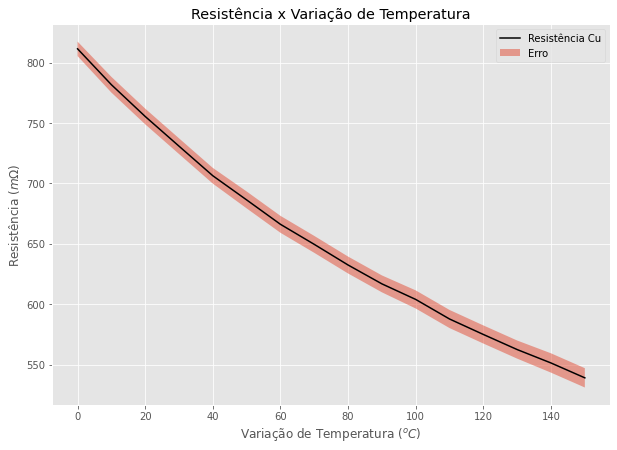

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10,7))

#Plotando os dados em si
ax1.plot(data_resist['$\Delta T (^oC)$'], 
         data_resist['$R\, (m\Omega)$'], label='Resistência Cu',
         c='k')

#Plotando a sombra de erro
ax1.fill_between(data_resist['$\Delta T (^oC)$'], 
                 data_resist['$R\, (m\Omega)$']-5*data_resist['$\Delta R$'], 
                 data_resist['$R\, (m\Omega)$']+5*data_resist['$\Delta R$'], alpha=0.5 , label='Erro')

#Adicionando titulo e legenda
ax1.set_title('Resistência x Variação de Temperatura')
ax1.set_xlabel('Variação de Temperatura $(^oC$)')
ax1.set_ylabel('Resistência ($m\Omega$)')

ax1.legend(loc=0)

## Linearização

Como vemos os dados representam de forma bem satisfatória o comportamento de um reta.

Para descobrirmos os valores dos coeficientes previstos pela teoria:

\begin{equation*}R=R_0+\alpha R_0 \Delta T\end{equation*}

Vamos utilizar estes dados para obtermos uma reta por regressão linear da forma:

\begin{equation*}R=A + B \Delta T\end{equation*}

In [ ]:
x = data_resist['$\Delta T (^oC)$']
X = sm.add_constant(data_resist['$\Delta T (^oC)$'])
y = data_resist['$R\, (m\Omega)$']

reta = sm.OLS(y,X).fit()
y_predicted = reta.predict(X)

reta.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        $R\, (m\Omega)$   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     663.1
Date:                Thu, 11 Mar 2021   Prob (F-statistic):           3.41e-13
Time:                        21:34:03   Log-Likelihood:                -62.239
No. Observations:                  16   AIC:                             128.5
Df Residuals:                      14   BIC:                             130.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              786.1066      6.040    130.148      0.000     773.152     799.061
$\Delta T (^oC)$    -1.7668      0.069    -25.752      0.000      -1.914      -1.620
==============================================================================
Omnibus:                        1.816   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.460
Skew:                           0.635   Prob(JB):                        0.482
Kurtosis:                       2.240   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

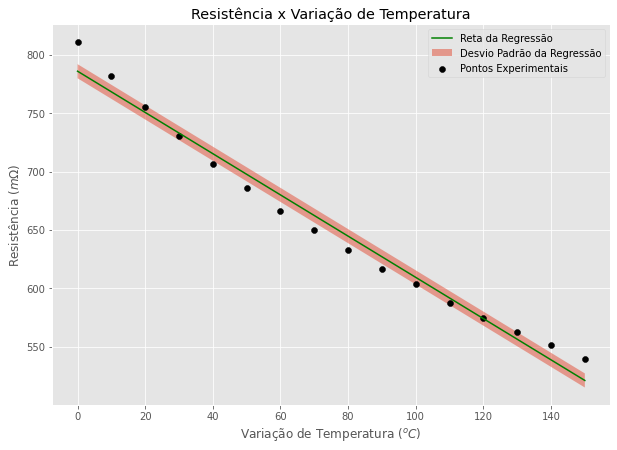

In [ ]:
fig2, ax2 = plt.subplots(figsize=(10,7))

ax2.plot(data_resist['$\Delta T (^oC)$'],y_predicted.values, label='Reta da Regressão', c='g')

ax2.fill_between(data_resist['$\Delta T (^oC)$'], 
                 y_predicted-reta.bse[0], 
                 y_predicted+reta.bse[0], alpha=0.5 , label='Desvio Padrão da Regressão')


#Plotando os dados em si
ax2.scatter(data_resist['$\Delta T (^oC)$'], 
         data_resist['$R\, (m\Omega)$'], label='Pontos Experimentais',
         c='k')

#Adicionando titulo e legenda
ax2.set_title('Resistência x Variação de Temperatura')
ax2.set_xlabel('Variação de Temperatura $(^oC$)')
ax2.set_ylabel('Resistência ($m\Omega$)')

ax2.legend(loc=0)

Assim obtemos a reta da regressão dada por:

\begin{equation*}R=(786\pm 6) - (1.77 \pm 0.07) \Delta T\end{equation*}

E comparando com a equação da teoria, temos que:

\begin{equation*}R_0 = 786 \pm 6\end{equation*}

\begin{equation*}\alpha R_0 = - 1.77 \pm 0.07\end{equation*}

Onde utilizando este valores podemos descobrir $\alpha$:

\begin{equation*}\alpha = - \frac{1.77}{786}\end{equation*}
\begin{equation*}\alpha = - 0.0023 \pm 0.0001\end{equation*}